In [2]:
# # Data collecting
# from bing_image_downloader import downloader
# downloader.download('face with mask',limit=600,output_dir='Data_Face_Mask',adult_filter_off=True)



In [5]:
# # Data collecting
# from bing_image_downloader import downloader
# downloader.download('face',limit=600,output_dir='Data_Face_Mask',adult_filter_off=True)


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
import tensorflow as tf

In [7]:
# Data Preprocessing

import cv2,os

data_path='Data_Face_Mask'
categories= os.listdir(data_path)
labels= [i for i in range(len(categories))]  # here we are making category for two item

label_dic= dict(zip(categories, labels))

print(categories)
print(labels)
print( label_dic)


['face', 'face with mask']
[0, 1]
{'face': 0, 'face with mask': 1}


In [8]:
img_size=100
data=[]
target=[]

for category in categories:
    folder_path= os.path.join(data_path, category)
    img_names= os.listdir(folder_path)
    
    for img_name in img_names:
        img_path= os.path.join(folder_path, img_name)
        img = cv2.imread(img_path)
        
        try:
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            
            # Converting the image into gray  scale
            resized= cv2.resize(gray,(img_size,img_size))
            # Resizing the gray scale into 100x100, since we need a fixed common size for all the images in
            data.append(resized)
            target.append(label_dic[category])
            # appending the image and the label( Category) into the list (dataset)
            
        except Exception as e:
                print('Exception :',e)
                
                # if any exception raised, the exception will be printed here, and pass to the next image 

In [9]:
import numpy as np
from keras.utils import np_utils

data= np.array(data)/255.0
data=np.reshape(data,(data.shape[0],img_size, img_size,1))
target= np.array(target)

new_target=np_utils.to_categorical(target)

In [10]:
np.save('data',data)
np.save('target',new_target)

In [11]:
# Training the CNN
data= np.load('data.npy')
target= np.load('target.npy')

In [12]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint

model= Sequential()

model.add(Conv2D(200,(3,3), input_shape= data.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

# The first CNN Layer followed by Relu and MaxPooling layers

model.add(Conv2D(100,(3,3),input_shape=data.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
# The second convolution layer followed by relu and Maxpooling layers

model.add(Flatten())
model.add(Dropout(0.5))
# Flatten layer to stock the output convolutions from second convolution layer


model.add(Dense(50,activation='relu'))
# Dense layer of 64 neurons
model.add(Dense(2,activation='softmax'))
# The Final layer with two output for two categories

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [13]:
from sklearn.model_selection import train_test_split

train_data, test_data, train_target, test_target= train_test_split(data,target, test_size=0.1)

In [14]:
checkpoint= ModelCheckpoint('model-{epoch:03d}.model', monitor='val_loss',verbose=0, save_best_only=True, mode='auto')
history= model.fit(train_data, train_target, epochs=20, callbacks=[checkpoint],validation_split=0.2)

Epoch 1/20
27/27 [==============================] - 74s 3s/step - loss: 0.7460 - accuracy: 0.5270 - val_loss: 0.5275 - val_accuracy: 0.7277
INFO:tensorflow:Assets written to: model-001.model\assets
Epoch 2/20
27/27 [==============================] - 72s 3s/step - loss: 0.4910 - accuracy: 0.7753 - val_loss: 0.4294 - val_accuracy: 0.8122
INFO:tensorflow:Assets written to: model-002.model\assets
Epoch 3/20
27/27 [==============================] - 70s 3s/step - loss: 0.4134 - accuracy: 0.8219 - val_loss: 0.3582 - val_accuracy: 0.9014
INFO:tensorflow:Assets written to: model-003.model\assets
Epoch 4/20
27/27 [==============================] - 71s 3s/step - loss: 0.2897 - accuracy: 0.8920 - val_loss: 0.2506 - val_accuracy: 0.9061
INFO:tensorflow:Assets written to: model-004.model\assets
Epoch 5/20
27/27 [==============================] - 72s 3s/step - loss: 0.1721 - accuracy: 0.9425 - val_loss: 0.1952 - val_accuracy: 0.9155
INFO:tensorflow:Assets written to: model-005.model\assets
Epoch 6/20

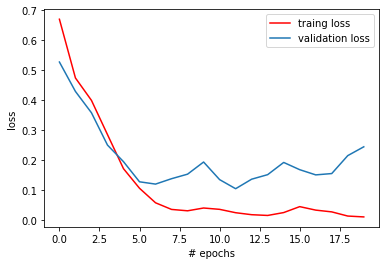

In [15]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'],'r',label='traing loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.show()


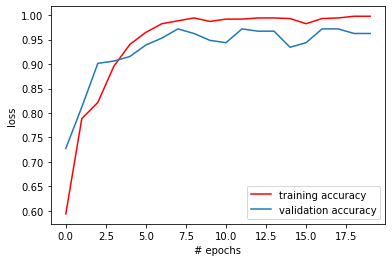

In [17]:
plt.plot(history.history['accuracy'],'r', label='training accuracy')
plt.plot(history.history['val_accuracy'],label='validation accuracy')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [18]:
print(model.evaluate(test_data, test_target))

4/4 [==============================] - 3s 874ms/step - loss: 0.3775 - accuracy: 0.9580
[0.37752845883369446, 0.9579831957817078]


In [20]:
# Detecting Faces with and without masks

from keras.models import load_model
import cv2

model =load_model('model-020.model')
face_clsfr= cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
source= cv2.VideoCapture(0)

labels_dict= {0:'MASK',1:'NO MASK'}
color_dict={0:(0,255,0),1:(0,0,255)}

while(True):
    ret,img=source.read()
    gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    faces=face_clsfr.detectMultiScale(gray,1.3,5)
    
    for x,y,w,h in faces:
        face_img= gray[y:y+w,x:x+w]
        resized=cv2.resize(face_img,(100,100))
        normalized= resized/255.0
        reshaped=np.reshape(normalized,(1,100,100,1))
        result= model.predict(reshaped)
        
        label=np.argmax(result,axis=1)[0]
        
        cv2.rectangle(img,(x,y),(x+w,y+h), color_dict[label],2)
        cv2.rectangle(img, label_dict[label],(x,y-10),cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,255,255),2)
        
    cv2.imshow('LIVE',img)
    key=cv2.waitKey(1)
    
    if( key==27):
        break
        
        
cv2.destroyAllWindow()
soorce.release()

error: OpenCV(4.4.0) C:\Users\appveyor\AppData\Local\Temp\1\pip-req-build-h4wtvo23\opencv\modules\objdetect\src\cascadedetect.cpp:1689: error: (-215:Assertion failed) !empty() in function 'cv::CascadeClassifier::detectMultiScale'
